# Assignment 5: Visual Servoing

The following has ALL the code to run the simulation and all the problems. You do not need to understand exactly how it works. You only need to work on the sections starting at "COMPLETE THIS". 

In [1]:
print("Hello:")

Hello:


In [82]:
#import matplotlib.pyplot as plt
import numpy as np
import pybullet as p
import pybullet_data
import os
import time
import cv2
from scipy.spatial.transform import Rotation as Rot            #can use this to apply angular rotations to coordinate frames

#camera (don't change these settings)
camera_width = 512                                             #image width
camera_height = 512                                            #image height
camera_fov = 120                                                #field of view of camera
camera_focal_depth = 0.5*camera_height/np.tan(0.5*np.pi/180*camera_fov) 
                                                               #focal depth in pixel space
camera_aspect = camera_width/camera_height                     #aspect ratio
camera_near = 0.02                                             #near clipping plane in meters, do not set non-zero
camera_far = 100                                               #far clipping plane in meters


#control objectives (if you wish, you can play with these values for fun)
object_location_desired = np.array([camera_width/2,camera_height/2])
                                                               #center the object to middle of image 
K_p_x = 0.1                                                    #Proportional control gain for translation
K_p_Omega = 0.02                                               #Proportional control gain for rotation       

### Create the Robot Class

In [83]:
# Robot with Camera Class
class eye_in_hand_robot:
    def get_ee_position(self):
        '''
        Function to return the end-effector of the link. This is the very tip of the robot at the end of the jaws.
        '''
        endEffectorIndex = self.numActiveJoints
        endEffectorState = p.getLinkState(self.robot_id, endEffectorIndex)
        endEffectorPos = np.array(endEffectorState[0])
        endEffectorOrn = np.array(p.getMatrixFromQuaternion(endEffectorState[1])).reshape(3,3)
        
        #add an offset to get past the forceps
        endEffectorPos += self.camera_offset*endEffectorOrn[:,2]
        return endEffectorPos, endEffectorOrn

    def get_current_joint_angles(self):
        # Get the current joint angles
        joint_angles = np.zeros(self.numActiveJoints)
        for i in range(self.numActiveJoints):
            joint_state = p.getJointState(self.robot_id, self._active_joint_indices[i])
            joint_angles[i] = joint_state[0]
        return joint_angles
    
    def get_jacobian_at_current_position(self):
        #Returns the Robot Jacobian of the last active link
        mpos, mvel, mtorq = self.get_active_joint_states()   
        zero_vec = [0.0]*len(mpos)
        linearJacobian, angularJacobian = p.calculateJacobian(self.robot_id, 
                                                              self.numActiveJoints,
                                                              [0,0,self.camera_offset],
                                                              mpos, 
                                                              zero_vec,
                                                              zero_vec)
        #only return the active joint's jacobians
        Jacobian = np.vstack((linearJacobian,angularJacobian))
        return Jacobian[:,:self.numActiveJoints]
    
    def set_joint_position(self, desireJointPositions, kp=1.0, kv=0.3):
        '''Set  the joint angle positions of the robot'''
        zero_vec = [0.0] * self._numLinkJoints
        allJointPositionObjectives = [0.0]*self._numLinkJoints
        for i in range(desireJointPositions.shape[0]):
            idx = self._active_joint_indices[i]
            allJointPositionObjectives[idx] = desireJointPositions[i]

        p.setJointMotorControlArray(self.robot_id,
                                    range(self._numLinkJoints),
                                    p.POSITION_CONTROL,
                                    targetPositions=allJointPositionObjectives,
                                    targetVelocities=zero_vec,
                                    positionGains=[kp] * self._numLinkJoints,
                                    velocityGains=[kv] * self._numLinkJoints)

    def get_active_joint_states(self):
        '''Get the states (position, velocity, and torques) of the active joints of the robot
        '''
        joint_states = p.getJointStates(self.robot_id, range(self._numLinkJoints))
        joint_infos = [p.getJointInfo(self.robot_id, i) for i in range(self._numLinkJoints)]
        joint_states = [j for j, i in zip(joint_states, joint_infos) if i[3] > -1]
        joint_positions = [state[0] for state in joint_states]
        joint_velocities = [state[1] for state in joint_states]
        joint_torques = [state[3] for state in joint_states]
        return joint_positions, joint_velocities, joint_torques


         
    def __init__(self, robot_id, initialJointPos):
        self.robot_id = robot_id
        self.eeFrameId = []
        self.camera_offset = 0.1 #offset camera in z direction to avoid grippers
        # Get the joint info
        self._numLinkJoints = p.getNumJoints(self.robot_id) #includes passive joint
        jointInfo = [p.getJointInfo(self.robot_id, i) for i in range(self._numLinkJoints)]
        
        # Get joint locations (some joints are passive)imgHeight
        self._active_joint_indices = []
        for i in range(self._numLinkJoints):
            if jointInfo[i][2]==p.JOINT_REVOLUTE:
                self._active_joint_indices.append(jointInfo[i][0])
        self.numActiveJoints = len(self._active_joint_indices) #exact number of active joints

        #reset joints
        for i in range(self._numLinkJoints):
            p.resetJointState(self.robot_id,i,initialJointPos[i])

### Ancilliary Functions

In [84]:
def draw_coordinate_frame(position, orientation, length, frameId = []):
    '''
    Draws a coordinate frame x,y,z with scaled lengths on the axes 
    in a position and orientation relative to the world coordinate frame
    pos: 3-element numpy array
    orientation: 3x3 numpy matrix
    length: length of the plotted x,y,z axes
    frameId: a unique ID for the frame. If this supplied, then it will erase the previous location of the frame
    
    returns the frameId
    '''
    if len(frameId)!=0:
        p.removeUserDebugItem(frameId[0])
        p.removeUserDebugItem(frameId[1])
        p.removeUserDebugItem(frameId[2])
    
    lineIdx=p.addUserDebugLine(position, position + np.dot(orientation, [length, 0, 0]), [1, 0, 0])  # x-axis in red
    lineIdy=p.addUserDebugLine(position, position + np.dot(orientation, [0, length, 0]), [0, 1, 0])  # y-axis in green
    lineIdz=p.addUserDebugLine(position, position + np.dot(orientation, [0, 0, length]), [0, 0, 1])  # z-axis in blue

    return lineIdx,lineIdy,lineIdz

def opengl_plot_world_to_pixelspace(pt_in_3D_to_project, viewMat, projMat, imgWidth, imgHeight):
    ''' Plots a x,y,z location in the world in an openCV image
    This is used for debugging, e.g. given a known location in the world, verify it appears in the camera
    when using p.getCameraImage(...). The output [u,v], when plot with opencv, should line up with object 
    in the image from p.getCameraImage(...)
    '''
    pt_in_3D_to_project = np.append(pt_in_3D_to_project,1)
    #print('Point in 3D to project:', pt_in_3D_to_project)

    pt_in_3D_in_camera_frame = viewMat @ pt_in_3D_to_project
    #print('Point in camera space: ', pt_in_3D_in_camera_frame)

    # Convert coordinates to get normalized device coordinates (before rescale)
    uvzw = projMat @ pt_in_3D_in_camera_frame
    #print('after projection: ', uvzw)

    # scale to get the normalized device coordinates
    uvzw_NDC = uvzw/uvzw[3]
    #print('after normalization: ', uvzw_NDC)

    #x,y specifies lower left corner of viewport rectangle, in pixels. initial value is (0,)
    u = ((uvzw_NDC[0] + 1) / 2.0) * imgWidth
    v = ((1-uvzw_NDC[1]) / 2.0) * imgHeight

    return [int(u),int(v)]

    
def get_camera_view_and_projection_opencv(cameraPos, camereaOrn):
    '''Gets the view and projection matrix for a camera at position (3) and orientation (3x3)'''
    __camera_view_matrix_opengl = p.computeViewMatrix(cameraEyePosition=cameraPos,
                                                   cameraTargetPosition=cameraPos+camereaOrn[:,2],
                                                   cameraUpVector=-camereaOrn[:,1])

    __camera_projection_matrix_opengl = p.computeProjectionMatrixFOV(camera_fov, camera_aspect, camera_near, camera_far)        
    _, _, rgbImg, depthImg, _ = p.getCameraImage(camera_width, 
                                                 camera_height, 
                                                 __camera_view_matrix_opengl,
                                                 __camera_projection_matrix_opengl, 
                                                 renderer=p.ER_BULLET_HARDWARE_OPENGL)

    #returns camera view and projection matrices in a form that fits openCV
    viewMat = np.array(__camera_view_matrix_opengl).reshape(4,4).T
    projMat = np.array(__camera_projection_matrix_opengl).reshape(4,4).T
    return viewMat, projMat

def get_camera_img_float(cameraPos, camereaOrn):
    ''' Gets the image and depth map from a camera at a position cameraPos (3) and cameraOrn (3x3) in space. '''
    __camera_view_matrix_opengl = p.computeViewMatrix(cameraEyePosition=cameraPos,
                                                   cameraTargetPosition=cameraPos+camereaOrn[:,2],
                                                   cameraUpVector=-camereaOrn[:,1])

    __camera_projection_matrix_opengl = p.computeProjectionMatrixFOV(camera_fov, camera_aspect, camera_near, camera_far)        
    width, height, rgbImg, nonlinDepthImg, _ = p.getCameraImage(camera_width, 
                                                 camera_height, 
                                                 __camera_view_matrix_opengl,
                                                 __camera_projection_matrix_opengl, 
                                                 renderer=p.ER_BULLET_HARDWARE_OPENGL)

    #adjust for clipping and nonlinear distance i.e., 1/d (0 is closest, i.e., near, 1 is furthest away, i.e., far
    depthImgLinearized =camera_far*camera_near/(camera_far+camera_near-(camera_far-camera_near)*nonlinDepthImg)

    #convert to numpy and a rgb-d image
    rgb_image = np.array(rgbImg[:,:,:3], dtype=np.uint8)
    depth_image = np.array(depthImgLinearized, dtype=np.float32)
    return rgb_image, depth_image


def dls_pinv(J, damping=0.01):

    U, S, Vt = np.linalg.svd(J, full_matrices=False)
    # Damped inverse of singular values
    S_damped = S / (S**2 + damping**2)
    # Form diagonal matrix
    S_inv = np.diag(S_damped)
    # Compute pseudoinverse
    J_pinv = Vt.T @ S_inv @ U.T
    return J_pinv

### Create Physics Environment

### COMPLETE THIS

In [85]:
## Q1: Show movement in Jacobian
def getImageJacobian(u_px,v_px,depthImg,focal_length, imgWidth, imgHeight):
    ''' Inputs: 
    u_px, v_px is pixel coordinates from image with top-left corner as 0,0
    depthImg is the depth map
    f is the focal length
    
    Outputs: image_jacobian, a 2x6 matrix'''
    f = focal_length
    # if(isinstance(x,(int,float))):
    #     u_px = np.array([u_px])
    #     v_px = np.array([v_px])
    u = (u_px-imgWidth/2)
    v = (-imgHeight/2+v_px)
    uv = u * v
    if(int(u_px) < 0 or int(u_px) >= imgWidth or int(v_px) < 0 or int(v_px) >= imgHeight):
        return np.zeros((2,6))
    z = depthImg[int(v_px),int(u_px)]
    image_jacobian = np.array([[-f/z,0,u/z,uv/f,-(f+u**2/f),v],[0,-f/z,v/z,(f+v**2/f),-uv/f,-u]])

    return image_jacobian 
    

In [86]:
def findCameraControl(object_loc_des, object_loc, image_jacobian):
    ''' Inputs:
    object_loc_des: desired [x,y] pixel locations for object
    object_loc: current [x,y] pixel locations as found from computer vision
    image_jacobian: the image jacobian 
    Outputs:
    delta_X: the scaled displacement in position of camera (world frame) to reduce the error
    delta_Omega: the scaled angular velocity of camera (world frame omega-x,y,z) to reduce the error
    
        '''
    image_jacobian_flattened = image_jacobian 
    L_inv = dls_pinv(image_jacobian_flattened)
    err = (object_loc_des - object_loc)
    err = err.reshape(-1,1)
    controls = L_inv@err
    delta_X = controls[:3,:]
    delta_Omega = controls[3:6,:]

    return delta_X, delta_Omega

In [ ]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi
def findJointControl(robot, delta_X, delta_Omega,null_space_enabled,roll,desired_roll,alpha=0.1):
    ''' Inputs:
    delta_X: the scaled displacement in position of camera (world frame) to reduce the error
    delta_Omega: the scaled angular velocity of camera (world frame omega-x,y,z) to reduce the error
    Outputs:
    delta_Q: the change in robot joints to cause the camera to move delta_X and delta_Omega
    '''

    J = robot.get_jacobian_at_current_position()
    J_inv = dls_pinv(J)
    
    q = robot.get_current_joint_angles()
    err = (np.vstack((delta_X,delta_Omega))).reshape(-1,1)
    dq = J_inv@err
    # print('dq is',dq)
    new_jointPositions = q.reshape(1,-1)[0] + dq.reshape(1,-1)[0]
    if null_space_enabled:
        J_inv_J = J_inv@J
        angle_err = wrap_angle(roll-desired_roll)
        # angle_err_2 = wrap_angle(roll-desired_roll-np.pi)
        # if abs(angle_err_1) < abs(angle_err_2):
        #     angle_err = angle_err_1
        # else:
        #     angle_err = angle_err_2

        print("angle_err is",angle_err)
        q2_dot = -100*angle_err*J[3,:].reshape(-1,1)
        q2_null = 2*(np.eye(J_inv_J.shape[0]) - J_inv_J)@q2_dot
        print('nullspace correction is',q2_null)
        new_jointPositions = new_jointPositions + q2_null.reshape(1,-1)[0]
    return new_jointPositions
def convert_delta_omega_to_cartesian(current_orientation, delta_omega):
    delta_omega = delta_omega.reshape(1,-1)[0]
    del_R_camera = Rot.from_euler('xyz', delta_omega, degrees=False).as_matrix()
    del_R_world = current_orientation@del_R_camera@current_orientation.T
    del_omega_world = Rot.from_matrix(del_R_world).as_euler('xyz', degrees=False)
    return del_omega_world



## SIMULATE ANSWERS

### Q1 and Q2 Setup

In [94]:
# Start the connection to the physics server
# p.disconnect()
physicsClient = p.connect(p.GUI)#(p.DIRECT)

time_step = 0.001
p.resetSimulation()
p.setTimeStep(time_step)
p.setGravity(0, 0, -9.8)

# Set the path to the URDF files included with PyBullet
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# load a plane URDF
p.loadURDF('plane.urdf')

# Place obstacles
box_length = box_width = 0.4
box_depth = 0.02
object_center = [0.3, 1, 0.01]
object_orientation = [0, 0, 0]
object_color = [0.8, 0.0, 0.0, 1]
geomBox = p.createCollisionShape(p.GEOM_BOX, halfExtents=[box_length/2, box_width/2, box_depth/2])
visualBox = p.createVisualShape(p.GEOM_BOX, halfExtents=[box_length/2, box_width/2, box_depth/2], rgbaColor=object_color)
boxId = p.createMultiBody(
    baseMass=0,
    baseCollisionShapeIndex=geomBox,
    baseVisualShapeIndex=visualBox,
    basePosition=np.array(object_center),
    baseOrientation=p.getQuaternionFromEuler(object_orientation)
)
ObjectModelPos, modelOrn  = p.getBasePositionAndOrientation(boxId)

#reset debug gui camera position so we can see the robot up close
p.resetDebugVisualizerCamera( cameraDistance=1, cameraYaw=30, cameraPitch=-52, cameraTargetPosition=[0,0,.5])


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 550.163.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 550.163.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [95]:
from PIL import Image
import numpy as np

cameraPosition = np.array([0.2,0,1])
cameraOrientation = np.array([[1,0,0],[0,-1,0],[0,0,-1]])
cRe = np.array([[1,0,0],[0,1,0],[0,0,1]])


logId = p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4, "robot_animation.mp4")   
frames = []
for ITER in range(100):
    p.stepSimulation()
 
    ''' Get Image'''
    rgb, depth = get_camera_img_float(cameraPosition, cameraOrientation)
    
    ''' Magical Computer Vision Algorithm that gets locations of objects in the image, as object_loc (Do Not Remove)'''
    viewMat, projMat = get_camera_view_and_projection_opencv(cameraPosition, cameraOrientation)
    object_loc = opengl_plot_world_to_pixelspace(object_center, viewMat, projMat,camera_width, camera_height)
    
    ''' Get Image Jacobian '''
    imageJacobian = getImageJacobian(object_loc[0], object_loc[1], depth, camera_focal_depth, camera_width, camera_height)

    ''' Get Camera Control '''
    delta_X_uv, delta_Omega_uv = findCameraControl(object_location_desired, object_loc, imageJacobian)
    
    ''' Apply Camera Controls'''

    # # For q1
    # if ITER < 30:
    #     delta_X_uv,delta_Omega_uv = np.array([0.0,0.1,0]),np.array([0,0,0])
    # elif ITER<60:
    #     delta_X_uv,delta_Omega_uv = np.array([0.1,0.0,0]),np.array([0,0,0])
    # else:
    #     delta_X_uv,delta_Omega_uv = np.array([0.0,0.0,0]),np.array([0,0,1])


    cameraOrientation = cameraOrientation@Rot.from_euler('xyz',0*K_p_Omega*cRe@delta_Omega_uv.reshape(3,), degrees=False).as_matrix()
    cameraPosition = cameraPosition + K_p_x*(cameraOrientation@cRe@delta_X_uv).reshape(3,)
    delta = np.vstack((delta_X_uv,delta_Omega_uv))
    uv_dot = (imageJacobian@delta.reshape(-1,1)).reshape(2,)
    u_dot,v_dot = uv_dot[0],uv_dot[1]


    # show image
    cv2.imshow("depth", depth)

    cv2.line(rgb, (object_loc[0],object_loc[1]),  (int(object_loc[0]+10*u_dot), int(object_loc[1]+10*v_dot)), (0, 0, 255), 2)
    cv2.circle(rgb, (int(object_loc[0]), int(object_loc[1])), 5, (0, 255, 0), -1)
    cv2.circle(rgb, (int(camera_width/2), int(camera_height/2)), 5, (255, 0, 255), -1)
    cv2.imshow("rgb", rgb)
    frames.append(Image.fromarray(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)))  # cv2 uses BGR, PIL uses RGB

    cv2.waitKey(1)
frames[0].save(
    'simulation.gif',
    save_all=True,
    append_images=frames[1:],
    duration=50,  # milliseconds per frame (adjust for speed)
    loop=0  # 0 = infinite loop
)
print("GIF saved as simulation.gif")
#close the physics server

cv2.destroyAllWindows()    

p.disconnect() 

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

GIF saved as simulation.gif
numActiveThreads = 0
stopping threads
destroy semaphore
semaphore destroyed
Thread with taskId 0 exiting
Thread TERMINATED
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


frame=  530 fps= 75 q=-1.0 Lsize=     182kB time=00:00:08.78 bitrate= 170.1kbits/s speed=1.25x    
video:175kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 4.016644%
[libx264 @ 0x60e00193cec0] frame I:3     Avg QP:18.15  size: 37974
[libx264 @ 0x60e00193cec0] frame P:134   Avg QP:21.70  size:   287
[libx264 @ 0x60e00193cec0] frame B:393   Avg QP:31.92  size:    67
[libx264 @ 0x60e00193cec0] consecutive B-frames:  1.1%  0.0%  0.0% 98.9%
[libx264 @ 0x60e00193cec0] mb I  I16..4: 36.6% 39.4% 24.0%
[libx264 @ 0x60e00193cec0] mb P  I16..4:  0.9%  0.3%  0.1%  P16..4:  1.1%  0.3%  0.1%  0.0%  0.0%    skip:97.3%
[libx264 @ 0x60e00193cec0] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  1.2%  0.0%  0.0%  direct: 0.0%  skip:98.6%  L0:68.9% L1:30.7% BI: 0.4%
[libx264 @ 0x60e00193cec0] 8x8 transform intra:34.9% inter:39.3%
[libx264 @ 0x60e00193cec0] direct mvs  spatial:96.7% temporal:3.3%
[libx264 @ 0x60e00193cec0] coded y,uvDC,uvAC intra: 10.5% 17.5% 14.4% inter: 0.0% 0.1

### Q3-Q4 Setup

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

roll angle is -3.118455928544061 -0.3843968692485613 0.666638646413064
dq is [[-0.04902417]
 [ 0.04522733]
 [ 0.04153642]
 [ 0.08399237]
 [ 0.0087308 ]
 [-0.01929602]
 [ 0.02687937]]
angle_err is -1.5476596017491646
nullspace correction is [[ 0.04257925]
 [-0.040114  ]
 [-0.04601074]
 [-0.07708573]
 [-0.00437542]
 [ 0.04455957]
 [-0.02274004]]
new_jointPositions is [-0.00644482 -0.78028477  0.78092462 -0.77849083  0.78975359  0.81066171
  0.7895375 ]
roll angle is -3.1184561608074812 -0.38439696886684427 0.6666392689173068
dq is [[-0.05018476]
 [ 0.04609961]
 [ 0.04265579]
 [ 0.08595902]
 [ 0.00847624]
 [-0.01977578]
 [ 0.02725367]]
angle_err is -1.5476598340125847
nullspace correction is [[ 0.04402637]
 [-0.04155808]
 [-0.04724206]
 [-0.08022811]
 [-0.00416729]
 [ 0.04566091]
 [-0.02347949]]
new_jointPositions is [-0.01255395 -0.77573178  0.77668631 -0.7724588   0.79408528  0.83652985
  0.79330251]
roll angle is -3.0921080821552733 -0.403948394566952 0.6569934970362998
dq is [[-0.0489

dq is [[ 0.01294865]
 [-0.01996395]
 [-0.01052688]
 [-0.02998786]
 [-0.00157406]
 [-0.00132753]
 [-0.00937916]]
angle_err is -0.6311245455360108
nullspace correction is [[-0.00034553]
 [-0.00948098]
 [-0.00092912]
 [-0.01317126]
 [ 0.00583785]
 [ 0.01417194]
 [-0.00046658]]
new_jointPositions is [ 0.23587607 -1.23485464  0.38102148 -1.50681056  0.93830191  1.74850709
  0.58129811]
roll angle is -2.0701985552689264 -0.9190734076429493 0.08945575801192529
dq is [[ 0.01267729]
 [-0.02141622]
 [-0.00993581]
 [-0.02945407]
 [-0.0021469 ]
 [-0.0027772 ]
 [-0.00811008]]
angle_err is -0.4994022284740298
nullspace correction is [[-9.03575743e-04]
 [-6.97661584e-03]
 [-2.25860948e-04]
 [-9.30946040e-03]
 [ 4.81239722e-03]
 [ 1.09221677e-02]
 [-9.91461894e-05]]
new_jointPositions is [ 0.27103619 -1.32059618  0.34974    -1.60241496  0.95449117  1.81625442
  0.55286274]
roll angle is -1.93813900743457 -0.9547744305974569 -0.0034462372697530164
dq is [[ 0.01200653]
 [-0.02222914]
 [-0.00933078]
 [-0

roll angle is -1.7683017501563594 -0.7611411190600141 -0.10952353789415037
dq is [[ 0.00272902]
 [-0.02144037]
 [-0.01079397]
 [-0.01640941]
 [-0.00923172]
 [-0.00892875]
 [-0.00116185]]
angle_err is -0.19750542336146282
nullspace correction is [[-7.32432388e-04]
 [-2.36699903e-03]
 [ 4.43005933e-05]
 [-2.65469678e-03]
 [ 2.40085760e-03]
 [ 3.46012845e-03]
 [ 9.83652911e-06]]
new_jointPositions is [ 0.57220022 -1.81118863  0.02984406 -2.35783708  0.78679896  1.79966888
  0.49847235]
roll angle is -1.8168520338614238 -0.6969474094585975 -0.07569835264593916
dq is [[ 0.00164658]
 [-0.01996685]
 [-0.01113592]
 [-0.01486808]
 [-0.00951087]
 [-0.00866645]
 [-0.00129309]]
angle_err is -0.24605570706652724
nullspace correction is [[-8.91162711e-04]
 [-2.95774384e-03]
 [-4.50393318e-05]
 [-3.28234446e-03]
 [ 2.98049786e-03]
 [ 4.19644747e-03]
 [-8.96240353e-07]]
new_jointPositions is [ 0.58482051 -1.82474364 -0.01113746 -2.40620358  0.75514397  1.78377829
  0.49860017]
roll angle is -1.8397610

dq is [[-0.00333812]
 [-0.00711883]
 [-0.01084252]
 [-0.00591846]
 [-0.00832363]
 [-0.00425437]
 [-0.00322699]]
angle_err is -0.3752416160564813
nullspace correction is [[-0.00127972]
 [-0.00447008]
 [-0.00190581]
 [-0.00436288]
 [ 0.00391137]
 [ 0.0047527 ]
 [-0.00023435]]
new_jointPositions is [ 0.57772637 -1.84686385 -0.32824907 -2.72296866  0.55030656  1.7538465
  0.47259877]
roll angle is -1.9373465454455863 -0.329480217460264 -0.017952999258594282
dq is [[-0.0037271 ]
 [-0.00602434]
 [-0.01090081]
 [-0.00525834]
 [-0.00823449]
 [-0.00397912]
 [-0.00342087]]
angle_err is -0.3665502186506897
nullspace correction is [[-0.00133193]
 [-0.0043288 ]
 [-0.00218811]
 [-0.00414972]
 [ 0.00366688]
 [ 0.00441288]
 [-0.00026378]]
new_jointPositions is [ 0.56613113 -1.85217233 -0.37674498 -2.75894854  0.52559276  1.76051553
  0.4638247 ]
roll angle is -1.931261382708283 -0.30013672306845773 -0.022776445946803392
dq is [[-0.00418998]
 [-0.0052145 ]
 [-0.01071612]
 [-0.00476531]
 [-0.00793578]
 

dq is [[-0.00638836]
 [-0.00132834]
 [-0.01087736]
 [-0.00283218]
 [-0.00732676]
 [-0.00415883]
 [-0.00451017]]
angle_err is -0.3002727789905588
nullspace correction is [[-0.0018159 ]
 [-0.00271499]
 [-0.00369475]
 [-0.00262804]
 [ 0.00216193]
 [ 0.00223187]
 [-0.00071103]]
new_jointPositions is [ 0.44567435 -1.83546809 -0.72172035 -2.94238847  0.37425597  1.81049335
  0.37597442]
roll angle is -1.8570132616411028 -0.13951857450843352 -0.06121582387031044
dq is [[-0.00667348]
 [-0.00063047]
 [-0.01107191]
 [-0.00259339]
 [-0.00739588]
 [-0.00426584]
 [-0.00483281]]
angle_err is -0.28621693484620625
nullspace correction is [[-0.00185326]
 [-0.00238868]
 [-0.00375493]
 [-0.00238633]
 [ 0.00196045]
 [ 0.00193918]
 [-0.00075687]]
new_jointPositions is [ 0.42289122 -1.83291071 -0.77305069 -2.9606299   0.35267383  1.81202741
  0.36022365]
roll angle is -1.8419747129303037 -0.12590950737553652 -0.06621077930497155
dq is [[-7.21688006e-03]
 [ 6.25420798e-05]
 [-1.17247784e-02]
 [-2.40916279e-0

dq is [[-0.00982441]
 [ 0.00470555]
 [-0.01404763]
 [-0.00118903]
 [-0.00939658]
 [-0.00716399]
 [-0.00826416]]
angle_err is -0.1705567891792521
nullspace correction is [[-0.001413  ]
 [-0.00026142]
 [-0.00292101]
 [-0.0008717 ]
 [ 0.00085155]
 [ 0.00045677]
 [-0.00074335]]
new_jointPositions is [ 0.21873926 -1.81425805 -1.16068775 -3.04932777  0.17180109  1.75811194
  0.22583498]
roll angle is -1.725965689793763 -0.09143926517186696 -0.0970628694293616
dq is [[-0.0092707 ]
 [ 0.0059157 ]
 [-0.0141938 ]
 [-0.00069556]
 [-0.00980544]
 [-0.00702847]
 [-0.00894201]]
angle_err is -0.1551693629988664
nullspace correction is [[-1.24348131e-03]
 [-5.98877131e-05]
 [-2.68665982e-03]
 [-7.05336683e-04]
 [ 7.46383216e-04]
 [ 3.43168620e-04]
 [-7.04541052e-04]]
new_jointPositions is [ 0.18581695 -1.80262696 -1.21891951 -3.05590342  0.14089378  1.74218152
  0.20126649]
roll angle is -1.7112821127437492 -0.09005495037529254 -0.1013382882588818
dq is [[-0.00895791]
 [ 0.00659769]
 [-0.01389401]
 [-0

dq is [[-0.00095015]
 [ 0.00709923]
 [-0.01032213]
 [ 0.00288095]
 [-0.00945781]
 [-0.00335875]
 [-0.00884388]]
angle_err is -0.03878774839351351
nullspace correction is [[ 1.12983653e-04]
 [ 1.32115500e-04]
 [-6.00885213e-04]
 [ 1.04403119e-04]
 [ 1.92219295e-04]
 [-1.36961341e-05]
 [-1.02330990e-04]]
new_jointPositions is [-0.03858715 -1.53388658 -1.77027047 -3.02486062 -0.22549477  1.59398741
 -0.14042734]
roll angle is -1.6043851505251379 -0.08151086300658617 -0.17179155340546215
dq is [[-0.0008652 ]
 [ 0.00664941]
 [-0.00991708]
 [ 0.00296109]
 [-0.00911781]
 [-0.0033553 ]
 [-0.00853006]]
angle_err is -0.0335888237302413
nullspace correction is [[ 1.28853021e-04]
 [ 9.85058077e-05]
 [-5.12990405e-04]
 [ 1.10775017e-04]
 [ 1.75434846e-04]
 [-1.98741610e-05]
 [-7.48709059e-05]]
new_jointPositions is [-0.04348543 -1.50837567 -1.80911893 -3.01513542 -0.25599602  1.5878011
 -0.17201535]
roll angle is -1.60001466334157 -0.08084064314275063 -0.1790194296991463
dq is [[-0.00051619]
 [ 0.0

dq is [[-0.00088376]
 [ 0.00329183]
 [-0.00585054]
 [ 0.00245128]
 [-0.00558214]
 [-0.00268242]
 [-0.00541285]]
angle_err is -0.015102332010940245
nullspace correction is [[ 1.24557289e-04]
 [-2.19078373e-05]
 [-2.03021551e-04]
 [ 1.06112583e-04]
 [ 1.14312838e-04]
 [-4.55936624e-05]
 [ 1.11284314e-05]]
new_jointPositions is [-0.0513865  -1.35909419 -2.05677666 -2.93000011 -0.45618219  1.55291612
 -0.38304676]
roll angle is -1.5852773972766556 -0.07666889153887757 -0.2231063036527483
dq is [[-0.00047548]
 [ 0.00279941]
 [-0.0055167 ]
 [ 0.00242086]
 [-0.00521226]
 [-0.00221447]
 [-0.00492536]]
angle_err is -0.014481070481759062
nullspace correction is [[ 1.23468802e-04]
 [-2.76733443e-05]
 [-1.91405889e-04]
 [ 1.06481879e-04]
 [ 1.13225875e-04]
 [-4.80351019e-05]
 [ 1.49311630e-05]]
new_jointPositions is [-0.05152448 -1.34678313 -2.08031168 -2.91983561 -0.47577253  1.54866417
 -0.40376598]
roll angle is -1.584804193905784 -0.07629296624463411 -0.22665207723932834
dq is [[-0.00059133]
 

dq is [[-0.00092441]
 [ 0.00166621]
 [-0.00277471]
 [ 0.00150142]
 [-0.00293825]
 [-0.00178089]
 [-0.00315272]]
angle_err is -0.01212866881068031
nullspace correction is [[ 1.18538653e-04]
 [-5.45839509e-05]
 [-1.42330450e-04]
 [ 1.10716784e-04]
 [ 1.12294452e-04]
 [-6.29261035e-05]
 [ 3.32031415e-05]]
new_jointPositions is [-0.06106538 -1.2790547  -2.2170762  -2.85255429 -0.5946406   1.51032584
 -0.53127857]
roll angle is -1.5826467877068797 -0.07392434607307052 -0.2433773918927189
dq is [[-0.00050893]
 [ 0.00129624]
 [-0.00277942]
 [ 0.00155714]
 [-0.00284126]
 [-0.00140585]
 [-0.00282623]]
angle_err is -0.011850460911983163
nullspace correction is [[ 1.16851777e-04]
 [-5.47597024e-05]
 [-1.38740073e-04]
 [ 1.09097980e-04]
 [ 1.10198543e-04]
 [-6.23443476e-05]
 [ 3.39766568e-05]]
new_jointPositions is [-0.06377794 -1.27486202 -2.22575955 -2.84722247 -0.6002549   1.50150605
 -0.58772822]
roll angle is -1.5781207066889937 -0.12133577656124328 -0.24217190802227906
dq is [[-0.00021844]
 

dq is [[ 0.00304836]
 [-0.00236135]
 [-0.0035839 ]
 [ 0.00269598]
 [-0.00252816]
 [ 0.00158166]
 [-0.0002588 ]]
angle_err is 0.03223051650890696
nullspace correction is [[-0.00031706]
 [ 0.00018578]
 [ 0.00034457]
 [-0.00032404]
 [-0.00032559]
 [ 0.00019858]
 [-0.00010766]]
new_jointPositions is [-0.05265923 -1.27895684 -2.31434985 -2.77854096 -0.67868638  1.42757712
 -1.10354026]
roll angle is -1.5444038988617503 -0.5780665166839447 -0.22051792319596508
dq is [[ 0.00331136]
 [-0.00272282]
 [-0.00318297]
 [ 0.00246369]
 [-0.00202051]
 [ 0.0019502 ]
 [ 0.00037702]]
angle_err is 0.026392427933146223
nullspace correction is [[-2.59795871e-04]
 [ 1.52860221e-04]
 [ 2.79028701e-04]
 [-2.67933662e-04]
 [-2.69423735e-04]
 [ 1.63891300e-04]
 [-8.58809451e-05]]
new_jointPositions is [-0.05108766 -1.28372007 -2.31484629 -2.77614044 -0.68957705  1.42440154
 -1.11979437]
roll angle is -1.55305026521817 -0.5961151172527313 -0.20810747900306525
dq is [[ 0.00303904]
 [-0.00255152]
 [-0.00266169]
 [ 0

dq is [[ 0.00611963]
 [-0.00552994]
 [-0.00250347]
 [ 0.00267437]
 [-0.00037462]
 [ 0.00442003]
 [ 0.00338107]]
angle_err is 0.021638600478577352
nullspace correction is [[-2.00891732e-04]
 [ 1.17282390e-04]
 [ 2.23212136e-04]
 [-2.20890025e-04]
 [-2.24719038e-04]
 [ 1.28342992e-04]
 [-5.02452605e-05]]
new_jointPositions is [-0.01702489 -1.34009672 -2.30636537 -2.75542684 -0.70581972  1.37715039
 -1.1164633 ]
roll angle is -1.5500315907425506 -0.6344372161074066 -0.13914872506935483
dq is [[ 0.00649245]
 [-0.0058066 ]
 [-0.0027028 ]
 [ 0.00298543]
 [-0.00054458]
 [ 0.00461483]
 [ 0.00340187]]
angle_err is 0.020764736052345967
nullspace correction is [[-1.88246644e-04]
 [ 1.10958498e-04]
 [ 2.11075101e-04]
 [-2.11642567e-04]
 [-2.17025790e-04]
 [ 1.22791274e-04]
 [-4.39459967e-05]]
new_jointPositions is [-0.00664181 -1.35390135 -2.30458558 -2.7505113  -0.70661746  1.37783826
 -1.09931116]
roll angle is -1.5530783888239466 -0.6278913881222812 -0.13011494414193026
dq is [[ 0.00660261]
 [-

dq is [[ 7.79438602e-03]
 [-6.79130619e-03]
 [-1.59364738e-03]
 [ 3.71277696e-03]
 [ 3.31348061e-06]
 [ 5.40177101e-03]
 [ 4.03602251e-03]]
angle_err is 0.019280005045040127
nullspace correction is [[-1.32849670e-04]
 [ 9.25421027e-05]
 [ 1.75185462e-04]
 [-1.89510251e-04]
 [-2.08756274e-04]
 [ 1.09845316e-04]
 [-6.40175228e-06]]
new_jointPositions is [ 0.09951783 -1.47999264 -2.28939751 -2.70363178 -0.69396174  1.38574355
 -0.99306541]
roll angle is -1.5524025491568327 -0.6207033414080452 -0.06749880728398328
dq is [[ 7.78370595e-03]
 [-6.72363039e-03]
 [-1.47872030e-03]
 [ 3.81489948e-03]
 [-7.72968087e-05]
 [ 5.32637831e-03]
 [ 3.89451671e-03]]
angle_err is 0.018393777638063824
nullspace correction is [[-1.19951393e-04]
 [ 8.72669026e-05]
 [ 1.63716586e-04]
 [-1.79646384e-04]
 [-2.00525496e-04]
 [ 1.04594498e-04]
 [-1.15815812e-06]]
new_jointPositions is [ 0.1182181  -1.50098721 -2.28619912 -2.69478087 -0.69277357  1.39077678
 -0.9793189 ]
roll angle is -1.5547692912309579 -0.622707

dq is [[ 6.73690060e-03]
 [-5.20362720e-03]
 [ 7.69674820e-04]
 [ 3.89425671e-03]
 [ 2.45704498e-05]
 [ 3.70179381e-03]
 [ 2.80684053e-03]]
angle_err is -0.011668920921630743
nullspace correction is [[ 2.99765869e-05]
 [-5.40887503e-05]
 [-8.55029907e-05]
 [ 1.03534938e-04]
 [ 1.35370388e-04]
 [-6.39608599e-05]
 [-2.85426143e-05]]
new_jointPositions is [ 0.34996846 -1.73447081 -2.22657291 -2.57303225 -0.68246499  1.46664407
 -0.8164856 ]
roll angle is -1.586056425235296 -0.6263749998129727 0.018028133559075066
dq is [[ 0.00646002]
 [-0.00493167]
 [ 0.00099682]
 [ 0.00369116]
 [ 0.00011676]
 [ 0.00348331]
 [ 0.00275836]]
angle_err is -0.015260098440399439
nullspace correction is [[ 3.47210042e-05]
 [-7.12137023e-05]
 [-1.10418125e-04]
 [ 1.34071422e-04]
 [ 1.77747534e-04]
 [-8.31398955e-05]
 [-3.96631290e-05]]
new_jointPositions is [ 0.37024608 -1.75271327 -2.21879    -2.56131233 -0.68207132  1.47418943
 -0.80405652]
roll angle is -1.5896978640507582 -0.6265932946219659 0.02226422273718

roll angle is -1.6085999284383758 -0.6170049109058201 0.04031302051851249
dq is [[ 0.00448177]
 [-0.0030183 ]
 [ 0.00136804]
 [ 0.00256884]
 [ 0.00021417]
 [ 0.00206333]
 [ 0.00184943]]
angle_err is -0.03780360164347929
nullspace correction is [[ 3.35381324e-05]
 [-1.96000350e-04]
 [-2.52505264e-04]
 [ 3.16121426e-04]
 [ 4.48203975e-04]
 [-2.09254416e-04]
 [-1.28454137e-04]]
new_jointPositions is [ 0.51202425 -1.83407908 -2.16082002 -2.47886754 -0.67095999  1.52340997
 -0.7404325 ]
roll angle is -1.6154088934258013 -0.6123191350703038 0.04869974224975149
dq is [[ 0.00443706]
 [-0.00297003]
 [ 0.00168727]
 [ 0.00232899]
 [ 0.00049798]
 [ 0.00207538]
 [ 0.0021295 ]]
angle_err is -0.04461256663090474
nullspace correction is [[ 4.03406681e-05]
 [-2.35806928e-04]
 [-2.95779766e-04]
 [ 3.73809332e-04]
 [ 5.28246807e-04]
 [-2.52547057e-04]
 [-1.54812829e-04]]
new_jointPositions is [ 0.52677834 -1.82926392 -2.15471037 -2.47235544 -0.66538112  1.52615699
 -0.74788424]
roll angle is -1.619080003

dq is [[ 0.00395378]
 [-0.00236523]
 [ 0.0016949 ]
 [ 0.00213157]
 [ 0.00052934]
 [ 0.00169364]
 [ 0.00177024]]
angle_err is -0.05066865768825313
nullspace correction is [[ 2.78669634e-05]
 [-2.99534299e-04]
 [-3.19523235e-04]
 [ 4.16163951e-04]
 [ 5.95718540e-04]
 [-3.10256379e-04]
 [-1.92620857e-04]]
new_jointPositions is [ 0.62811235 -1.83475883 -2.11707046 -2.41800976 -0.62963681  1.55803053
 -0.75130321]
roll angle is -1.6216975595604737 -0.613072920930687 0.06817534230950217
dq is [[ 0.00396193]
 [-0.00232913]
 [ 0.0017106 ]
 [ 0.00216076]
 [ 0.00053346]
 [ 0.00166704]
 [ 0.00173943]]
angle_err is -0.05090123276557712
nullspace correction is [[ 2.59285200e-05]
 [-3.05326013e-04]
 [-3.18361524e-04]
 [ 4.16998542e-04]
 [ 5.97755399e-04]
 [-3.14758587e-04]
 [-1.95052857e-04]]
new_jointPositions is [ 0.64193625 -1.83551972 -2.11179229 -2.40982672 -0.62452575  1.56192617
 -0.75168948]
roll angle is -1.621839856070869 -0.6126524242138465 0.06940182282789609
dq is [[ 0.0036756 ]
 [-0.00

dq is [[ 0.00317072]
 [-0.00165137]
 [ 0.00172274]
 [ 0.00160376]
 [ 0.00067779]
 [ 0.00127201]
 [ 0.00154613]]
angle_err is -0.05314801527553037
nullspace correction is [[ 1.80450279e-05]
 [-3.48750127e-04]
 [-3.12880210e-04]
 [ 4.29694849e-04]
 [ 6.17964867e-04]
 [-3.50161439e-04]
 [-2.10804107e-04]]
new_jointPositions is [ 0.72932357 -1.83458999 -2.07711363 -2.35580712 -0.58946353  1.58284836
 -0.75460536]
roll angle is -1.6241429099027629 -0.6068463603237704 0.07831487336673604
dq is [[ 0.00317878]
 [-0.00162574]
 [ 0.00172651]
 [ 0.00162778]
 [ 0.00067815]
 [ 0.00125532]
 [ 0.00152349]]
angle_err is -0.05334658310786633
nullspace correction is [[ 1.70988783e-05]
 [-3.53880474e-04]
 [-3.11375938e-04]
 [ 4.30436631e-04]
 [ 6.19318155e-04]
 [-3.53885884e-04]
 [-2.12040174e-04]]
new_jointPositions is [ 0.74060734 -1.83452399 -2.07243927 -2.34847415 -0.58479331  1.58534855
 -0.75335439]
roll angle is -1.6243475882811058 -0.6046731335384317 0.07908241467447441
dq is [[ 0.00318837]
 [-0.

roll angle is -1.6244923310546096 -0.5837212122167731 0.08126300021324928
dq is [[ 0.00244101]
 [-0.00108524]
 [ 0.00135936]
 [ 0.00129734]
 [ 0.00054085]
 [ 0.00089197]
 [ 0.00108807]]
angle_err is -0.05369600425971299
nullspace correction is [[ 1.07453462e-05]
 [-3.83578060e-04]
 [-2.93027333e-04]
 [ 4.25894878e-04]
 [ 6.15569004e-04]
 [-3.70905824e-04]
 [-2.13399001e-04]]
new_jointPositions is [ 0.82037405 -1.83407162 -2.03829948 -2.29432266 -0.55008711  1.60192486
 -0.73442743]
roll angle is -1.624152120569243 -0.5804240209779814 0.081112635844371
dq is [[ 0.00217913]
 [-0.00096039]
 [ 0.00112995]
 [ 0.00120904]
 [ 0.00042329]
 [ 0.00078439]
 [ 0.00088956]]
angle_err is -0.053355793774346516
nullspace correction is [[ 1.01223860e-05]
 [-3.84061342e-04]
 [-2.88876386e-04]
 [ 4.22299728e-04]
 [ 6.10722984e-04]
 [-3.69899074e-04]
 [-2.11670371e-04]]
new_jointPositions is [ 0.82875633 -1.83394669 -2.0347867  -2.28829025 -0.54618704  1.60348687
 -0.73178327]
roll angle is -1.62377275318

dq is [[ 0.00111515]
 [-0.00043448]
 [ 0.00054742]
 [ 0.00066043]
 [ 0.0001975 ]
 [ 0.00037279]
 [ 0.0003889 ]]
angle_err is -0.04394603142953635
nullspace correction is [[ 5.76937046e-06]
 [-3.35595898e-04]
 [-2.22533734e-04]
 [ 3.40411425e-04]
 [ 4.95343527e-04]
 [-3.11907014e-04]
 [-1.68428519e-04]]
new_jointPositions is [ 0.89785382 -1.83337032 -2.00516293 -2.23634981 -0.50838934  1.61341884
 -0.70865657]
roll angle is -1.6136248665193165 -0.5494172420882786 0.07500341878967909
dq is [[ 0.00111661]
 [-0.00043158]
 [ 0.00054688]
 [ 0.00066544]
 [ 0.00019731]
 [ 0.00036998]
 [ 0.00038494]]
angle_err is -0.04282853972441991
nullspace correction is [[ 5.63394438e-06]
 [-3.28273844e-04]
 [-2.15746176e-04]
 [ 3.31413865e-04]
 [ 4.82270238e-04]
 [-3.04595182e-04]
 [-1.63585431e-04]]
new_jointPositions is [ 0.90246886 -1.83336007 -2.00349141 -2.23252012 -0.50567287  1.61382339
 -0.70743132]
roll angle is -1.6124606617217312 -0.5475907304897236 0.07434357945449399
dq is [[ 0.00111787]
 [-0.

roll angle is -1.6040870800904568 -0.5418666382399171 0.07087967929431871
dq is [[ 1.10757830e-03]
 [-4.51629701e-04]
 [ 2.29422736e-04]
 [ 8.88306199e-04]
 [-1.48590085e-05]
 [ 2.87756064e-04]
 [ 7.18577096e-05]]
angle_err is -0.033290753295560194
nullspace correction is [[ 5.42177745e-06]
 [-2.61122195e-04]
 [-1.61230354e-04]
 [ 2.57157133e-04]
 [ 3.72594357e-04]
 [-2.41330696e-04]
 [-1.24302406e-04]]
new_jointPositions is [ 0.93331315 -1.83336297 -1.99534506 -2.2046572  -0.48769219  1.61340647
 -0.71186971]
roll angle is -1.6026274840865824 -0.5449679579034681 0.07109573679495584
dq is [[ 1.10722837e-03]
 [-4.50154892e-04]
 [ 2.31750109e-04]
 [ 8.88101782e-04]
 [-1.26954171e-05]
 [ 2.86546322e-04]
 [ 7.23981339e-05]]
angle_err is -0.03183115729168584
nullspace correction is [[ 5.46086790e-06]
 [-2.50225078e-04]
 [-1.53438250e-04]
 [ 2.46019401e-04]
 [ 3.55995810e-04]
 [-2.31380454e-04]
 [-1.18652410e-04]]
new_jointPositions is [ 0.93685233 -1.83335864 -1.99473074 -2.20124387 -0.4856

dq is [[ 1.38535400e-03]
 [-5.74006315e-04]
 [ 1.64722145e-04]
 [ 1.21783026e-03]
 [-9.65164163e-05]
 [ 3.11635800e-04]
 [-4.38952666e-05]]
angle_err is -0.024036344443453928
nullspace correction is [[ 5.87009432e-06]
 [-1.91808100e-04]
 [-1.11483790e-04]
 [ 1.87191974e-04]
 [ 2.67677023e-04]
 [-1.78549436e-04]
 [-8.90748378e-05]]
new_jointPositions is [ 0.96309824 -1.83344097 -1.99064274 -2.17561656 -0.47361467  1.6051016
 -0.75636012]
roll angle is -1.5940539996952001 -0.579626988037844 0.07630863090993989
dq is [[ 1.38635592e-03]
 [-5.72601971e-04]
 [ 1.70102746e-04]
 [ 1.21759034e-03]
 [-9.22459997e-05]
 [ 3.10579839e-04]
 [-4.10782784e-05]]
angle_err is -0.02325767290030356
nullspace correction is [[ 5.97973470e-06]
 [-1.86009513e-04]
 [-1.07136011e-04]
 [ 1.81452098e-04]
 [ 2.58874191e-04]
 [-1.73416492e-04]
 [-8.62084408e-05]]
new_jointPositions is [ 0.96727365 -1.83344098 -1.99004218 -2.17153033 -0.47211981  1.60386039
 -0.76361053]
roll angle is -1.5933739360425632 -0.58547746

dq is [[ 1.39425231e-03]
 [-5.54437172e-04]
 [ 2.03178294e-04]
 [ 1.22402293e-03]
 [-6.39776194e-05]
 [ 2.95763499e-04]
 [-2.91374223e-05]]
angle_err is -0.022697602336331002
nullspace correction is [[ 7.71251447e-06]
 [-1.84834994e-04]
 [-9.85152441e-05]
 [ 1.78971404e-04]
 [ 2.51950914e-04]
 [-1.73265293e-04]
 [-8.35967055e-05]]
new_jointPositions is [ 1.00033957 -1.83333867 -1.98106655 -2.13916863 -0.46216666  1.59849982
 -0.8011208 ]
roll angle is -1.594154504273061 -0.6153790793567102 0.08419466297954359
dq is [[ 1.39503927e-03]
 [-5.51641196e-04]
 [ 2.04954270e-04]
 [ 1.22706699e-03]
 [-6.19221372e-05]
 [ 2.92365150e-04]
 [-3.02774297e-05]]
angle_err is -0.0233581774781646
nullspace correction is [[ 8.12139250e-06]
 [-1.90648116e-04]
 [-1.00576260e-04]
 [ 1.84342652e-04]
 [ 2.59233954e-04]
 [-1.78706966e-04]
 [-8.58595922e-05]]
new_jointPositions is [ 1.00438642 -1.83333029 -1.97954151 -2.13517759 -0.46108617  1.59840333
 -0.80291095]
roll angle is -1.5948216410356229 -0.61659931

dq is [[ 8.47253451e-04]
 [-3.32669312e-04]
 [ 7.04011502e-05]
 [ 7.93126882e-04]
 [-7.02020820e-05]
 [ 1.52200886e-04]
 [-8.01742153e-05]]
angle_err is -0.026824572807352176
nullspace correction is [[ 1.15690858e-05]
 [-2.22984490e-04]
 [-1.07518592e-04]
 [ 2.13001818e-04]
 [ 2.97102085e-04]
 [-2.08833941e-04]
 [-9.53754471e-05]]
new_jointPositions is [ 1.03842092 -1.83315679 -1.96601799 -2.0987454  -0.44894945  1.59540955
 -0.8162364 ]
roll angle is -1.5972659462260563 -0.6247315346539805 0.08511229349678151
dq is [[ 8.47451806e-04]
 [-3.31772678e-04]
 [ 7.06825348e-05]
 [ 7.94221682e-04]
 [-6.97115462e-05]
 [ 1.50973305e-04]
 [-8.08963458e-05]]
angle_err is -0.026469619431159774
nullspace correction is [[ 1.15951772e-05]
 [-2.20298607e-04]
 [-1.05597750e-04]
 [ 2.10191231e-04]
 [ 2.93076592e-04]
 [-2.06251713e-04]
 [-9.37508358e-05]]
new_jointPositions is [ 1.04082052 -1.83314294 -1.96503066 -2.09602515 -0.44763884  1.59491064
 -0.81667328]
roll angle is -1.5968439588396055 -0.62478

dq is [[ 5.90053543e-04]
 [-2.72750962e-04]
 [-1.43281901e-04]
 [ 6.89566626e-04]
 [-1.80023927e-04]
 [ 5.83828861e-05]
 [-2.42488559e-04]]
angle_err is -0.023110530748156943
nullspace correction is [[ 1.12182507e-05]
 [-1.93408368e-04]
 [-8.98184534e-05]
 [ 1.83560263e-04]
 [ 2.55514395e-04]
 [-1.80861803e-04]
 [-7.94968831e-05]]
new_jointPositions is [ 1.05304788 -1.83305141 -1.95963757 -2.08007609 -0.43982055  1.59055344
 -0.81895864]
roll angle is -1.5935355176365593 -0.6245863875150707 0.08230124723640375
dq is [[ 5.90179934e-04]
 [-2.72603847e-04]
 [-1.43005070e-04]
 [ 6.89902185e-04]
 [-1.79766927e-04]
 [ 5.79052522e-05]
 [-2.42681736e-04]]
angle_err is -0.022739190841662982
nullspace correction is [[ 1.11830737e-05]
 [-1.90410439e-04]
 [-8.80814158e-05]
 [ 1.80634397e-04]
 [ 2.51386787e-04]
 [-1.78055444e-04]
 [-7.79068958e-05]]
new_jointPositions is [ 1.0544733  -1.83304924 -1.95895768 -2.07808251 -0.43891947  1.5900149
 -0.81941603]
roll angle is -1.5932105838590507 -0.624753

dq is [[ 3.34660696e-04]
 [-2.20790734e-04]
 [-3.52982554e-04]
 [ 5.85102566e-04]
 [-2.89818201e-04]
 [-3.35803092e-05]
 [-3.99899243e-04]]
angle_err is -0.01995583824078384
nullspace correction is [[ 1.07458534e-05]
 [-1.67600697e-04]
 [-7.57299447e-05]
 [ 1.58604530e-04]
 [ 2.20477304e-04]
 [-1.56698166e-04]
 [-6.63769006e-05]]
new_jointPositions is [ 1.06304756 -1.83298981 -1.95465853 -2.064854   -0.43267917  1.58500222
 -0.82359029]
roll angle is -1.5902750578577618 -0.6268464014246224 0.07961207062593745
dq is [[ 3.35072742e-04]
 [-2.21067346e-04]
 [-3.52695887e-04]
 [ 5.85195614e-04]
 [-2.89870898e-04]
 [-3.35047278e-05]
 [-3.99753378e-04]]
angle_err is -0.01947873106286524
nullspace correction is [[ 1.05786816e-05]
 [-1.63604382e-04]
 [-7.38406742e-05]
 [ 1.54796509e-04]
 [ 2.15182090e-04]
 [-1.52951809e-04]
 [-6.46000680e-05]]
new_jointPositions is [ 1.06361292 -1.8329759  -1.95431703 -2.06380086 -0.43202217  1.58426844
 -0.82434362]
roll angle is -1.5897729777013248 -0.6274289

roll angle is -1.5853627995550652 -0.6342578663988574 0.07865039698229448
dq is [[ 3.40742951e-04]
 [-2.24113988e-04]
 [-3.49345427e-04]
 [ 5.86906688e-04]
 [-2.90391900e-04]
 [-3.18374988e-05]
 [-3.97911811e-04]]
angle_err is -0.014566472760168647
nullspace correction is [[ 8.52281821e-06]
 [-1.22380444e-04]
 [-5.47321752e-05]
 [ 1.15630184e-04]
 [ 1.60743087e-04]
 [-1.14312324e-04]
 [-4.70744078e-05]]
new_jointPositions is [ 1.0686935  -1.83294845 -1.95118537 -2.0543062  -0.42617561  1.57691688
 -0.83328897]
roll angle is -1.5850633693904077 -0.6349669235901418 0.07861366688215599
dq is [[ 3.41306183e-04]
 [-2.24386481e-04]
 [-3.49005422e-04]
 [ 5.87164771e-04]
 [-2.90394443e-04]
 [-3.17044278e-05]
 [-3.97752691e-04]]
angle_err is -0.01426704259551137
nullspace correction is [[ 8.40103894e-06]
 [-1.19867454e-04]
 [-5.35585330e-05]
 [ 1.13253357e-04]
 [ 1.57429636e-04]
 [-1.11964791e-04]
 [-4.60148191e-05]]
new_jointPositions is [ 1.06914934 -1.83293593 -1.95091419 -2.05348244 -0.4257

roll angle is -1.5847436254492075 -0.6408047080005503 0.07908803801127129
dq is [[ 3.46326206e-04]
 [-2.26825402e-04]
 [-3.45134396e-04]
 [ 5.90874547e-04]
 [-2.89190524e-04]
 [-3.14389944e-05]
 [-3.96737762e-04]]
angle_err is -0.013947298654310991
nullspace correction is [[ 8.76654231e-06]
 [-1.17288521e-04]
 [-5.15229810e-05]
 [ 1.11002245e-04]
 [ 1.53970352e-04]
 [-1.09741150e-04]
 [-4.42321661e-05]]
new_jointPositions is [ 1.07500276 -1.83294034 -1.94778155 -2.04400944 -0.42333707  1.5718858
 -0.84132283]
roll angle is -1.5849577303596394 -0.6415669521259517 0.07919927760740997
dq is [[ 3.47013445e-04]
 [-2.27119238e-04]
 [-3.44561899e-04]
 [ 5.91525665e-04]
 [-2.88959496e-04]
 [-3.15249301e-05]
 [-3.96644284e-04]]
angle_err is -0.014161403564743047
nullspace correction is [[ 8.97526488e-06]
 [-1.19101201e-04]
 [-5.21928424e-05]
 [ 1.12751231e-04]
 [ 1.56353018e-04]
 [-1.11465260e-04]
 [-4.48046294e-05]]
new_jointPositions is [ 1.07575627 -1.83296367 -1.94734094 -2.04273153 -0.4230

dq is [[ 3.51388631e-04]
 [-2.29017515e-04]
 [-3.41390246e-04]
 [ 5.94780407e-04]
 [-2.88168127e-04]
 [-3.13750688e-05]
 [-3.95799638e-04]]
angle_err is -0.014060428386654777
nullspace correction is [[ 9.35543742e-06]
 [-1.18286358e-04]
 [-5.12473550e-05]
 [ 1.12121262e-04]
 [ 1.55285471e-04]
 [-1.10818107e-04]
 [-4.38225676e-05]]
new_jointPositions is [ 1.07982043 -1.83295435 -1.94491937 -2.03553798 -0.42096406  1.56738594
 -0.84824459]
roll angle is -1.5847459064517353 -0.6474048395019091 0.0795514761196906
dq is [[ 3.51998368e-04]
 [-2.29284080e-04]
 [-3.40978604e-04]
 [ 5.95176527e-04]
 [-2.88088913e-04]
 [-3.13084055e-05]
 [-3.95664846e-04]]
angle_err is -0.01394957965683874
nullspace correction is [[ 9.33986909e-06]
 [-1.17357974e-04]
 [-5.07745993e-05]
 [ 1.11254480e-04]
 [ 1.54063368e-04]
 [-1.09960168e-04]
 [-4.33870069e-05]]
new_jointPositions is [ 1.08034838 -1.83294285 -1.94460952 -2.0346001  -0.42063248  1.56682363
 -0.84909784]
roll angle is -1.5846271905545701 -0.6481280

roll angle is -1.5840720568248379 -0.6524741943489145 0.07981809823349906
dq is [[ 3.56222524e-04]
 [-2.31089843e-04]
 [-3.38056865e-04]
 [ 5.97986561e-04]
 [-2.87480237e-04]
 [-3.08588808e-05]
 [-3.94773011e-04]]
angle_err is -0.013275730029941535
nullspace correction is [[ 9.27500489e-06]
 [-1.11710928e-04]
 [-4.78471168e-05]
 [ 1.06012237e-04]
 [ 1.46652165e-04]
 [-1.04754805e-04]
 [-4.07037156e-05]]
new_jointPositions is [ 1.0840587  -1.83294873 -1.94240307 -2.02797962 -0.41852892  1.56293655
 -0.85501485]
roll angle is -1.5840118446819118 -0.6532005718291569 0.07984039588731673
dq is [[ 3.56838842e-04]
 [-2.31348648e-04]
 [-3.37629373e-04]
 [ 5.98419456e-04]
 [-2.87379550e-04]
 [-3.08099511e-05]
 [-3.94647700e-04]]
angle_err is -0.013215517887015249
nullspace correction is [[ 9.28926133e-06]
 [-1.11208023e-04]
 [-4.75602323e-05]
 [ 1.05553545e-04]
 [ 1.45992254e-04]
 [-1.04298786e-04]
 [-4.04372951e-05]]
new_jointPositions is [ 1.08460056 -1.83293846 -1.94209058 -2.02702411 -0.418

dq is [[ 3.64298992e-04]
 [-2.34378610e-04]
 [-3.32280678e-04]
 [ 6.03960156e-04]
 [-2.85904302e-04]
 [-3.03894753e-05]
 [-3.93262710e-04]]
angle_err is -0.01299116074393103
nullspace correction is [[ 9.81110239e-06]
 [-1.09363837e-04]
 [-4.58544775e-05]
 [ 1.04082512e-04]
 [ 1.43618943e-04]
 [-1.02789140e-04]
 [-3.87844010e-05]]
new_jointPositions is [ 1.0913413  -1.83294269 -1.93818586 -2.01512553 -0.41515702  1.55600525
 -0.86611404]
roll angle is -1.5837997644369741 -0.662648332261973 0.08054947009989954
dq is [[ 3.64925396e-04]
 [-2.34623286e-04]
 [-3.31815959e-04]
 [ 6.04448459e-04]
 [-2.85771371e-04]
 [-3.03696870e-05]
 [-3.93158223e-04]]
angle_err is -0.013003437642077564
nullspace correction is [[ 9.87954918e-06]
 [-1.09469431e-04]
 [-4.58180828e-05]
 [ 1.04212129e-04]
 [ 1.43766290e-04]
 [-1.02909241e-04]
 [-3.87403834e-05]]
new_jointPositions is [ 1.09192457 -1.83295561 -1.93784431 -2.01408938 -0.41492831  1.55545138
 -0.86696957]
roll angle is -1.58382206448251 -0.663381415

dq is [[ 0.00012656]
 [-0.00020222]
 [-0.00053605]
 [ 0.00051597]
 [-0.00040057]
 [-0.00011813]
 [-0.0005485 ]]
angle_err is -0.013171368653126514
nullspace correction is [[ 1.04355090e-05]
 [-1.10909661e-04]
 [-4.58298543e-05]
 [ 1.05790130e-04]
 [ 1.45704623e-04]
 [-1.04426641e-04]
 [-3.86556711e-05]]
new_jointPositions is [ 1.09587038 -1.83291564 -1.93567514 -2.00681561 -0.41334945  1.55157448
 -0.87321528]
roll angle is -1.583997634456996 -0.6685227926903411 0.08109678037392787
dq is [[ 0.00012743]
 [-0.00020267]
 [-0.0005356 ]
 [ 0.0005167 ]
 [-0.00040061]
 [-0.00011806]
 [-0.00054842]]
angle_err is -0.01320130766209937
nullspace correction is [[ 1.05086406e-05]
 [-1.11152868e-04]
 [-4.58914264e-05]
 [ 1.06047177e-04]
 [ 1.46042095e-04]
 [-1.04670509e-04]
 [-3.86722389e-05]]
new_jointPositions is [ 1.09620557 -1.83291527 -1.93544497 -2.00607642 -0.41311875  1.55099368
 -0.87420075]
roll angle is -1.5838853447756778 -0.6694076381870468 0.08116768829196574
dq is [[ 0.00012844]
 [-0.

dq is [[ 6.86056131e-04]
 [-3.72967315e-04]
 [-3.80167067e-04]
 [ 9.72513511e-04]
 [-3.65210154e-04]
 [-7.98435973e-06]
 [-5.09837245e-04]]
angle_err is -0.011894501324815288
nullspace correction is [[ 9.78806667e-06]
 [-1.00140726e-04]
 [-4.10231431e-05]
 [ 9.56636689e-05]
 [ 1.31592064e-04]
 [-9.43826959e-05]
 [-3.44470194e-05]]
new_jointPositions is [ 1.10003071 -1.83306992 -1.93355083 -1.99988152 -0.4112386   1.54690147
 -0.88189921]
roll angle is -1.5829581956665875 -0.6763355958437538 0.08204085705985731
dq is [[ 3.76717993e-04]
 [-2.39000281e-04]
 [-3.24404082e-04]
 [ 6.12961638e-04]
 [-2.84247684e-04]
 [-2.89216849e-05]
 [-3.91210666e-04]]
angle_err is -0.012161868871690906
nullspace correction is [[ 1.00873773e-05]
 [-1.02398650e-04]
 [-4.18205048e-05]
 [ 9.78798958e-05]
 [ 1.34573998e-04]
 [-9.65545258e-05]
 [-3.51438760e-05]]
new_jointPositions is [ 1.10063703 -1.83295092 -1.93300906 -1.99875655 -0.41103508  1.54623644
 -0.88291863]
roll angle is -1.5832859480079473 -0.67729

dq is [[ 3.81774180e-04]
 [-2.40710201e-04]
 [-3.20880312e-04]
 [ 6.16785407e-04]
 [-2.83405739e-04]
 [-2.88784090e-05]
 [-3.90246581e-04]]
angle_err is -0.012310895043001757
nullspace correction is [[ 1.05902062e-05]
 [-1.03649409e-04]
 [-4.19191898e-05]
 [ 9.92052435e-05]
 [ 1.36249379e-04]
 [-9.78172042e-05]
 [-3.50372345e-05]]
new_jointPositions is [ 1.10443467 -1.83292848 -1.93082942 -1.99192717 -0.40884738  1.54166519
 -0.88979804]
roll angle is -1.5823727271037251 -0.6833293622522113 0.08289118090334202
dq is [[ 4.57205876e-04]
 [-3.45861933e-04]
 [-5.80427693e-04]
 [ 8.91445126e-04]
 [-4.81029639e-04]
 [-9.43502496e-05]
 [-6.64390225e-04]]
angle_err is -0.01157640030882856
nullspace correction is [[ 9.98319628e-06]
 [-9.74606811e-05]
 [-3.94167883e-05]
 [ 9.32643258e-05]
 [ 1.28105731e-04]
 [-9.19579417e-05]
 [-3.28938850e-05]]
new_jointPositions is [ 1.10476198 -1.8330414  -1.93093259 -1.99116284 -0.40863405  1.54096228
 -0.89108757]
roll angle is -1.5818791831300736 -0.684298

dq is [[ 4.73745314e-04]
 [-3.53423595e-04]
 [-5.68841602e-04]
 [ 9.04758368e-04]
 [-4.77616920e-04]
 [-9.37477762e-05]
 [-6.62110055e-04]]
angle_err is -0.011869200951563297
nullspace correction is [[ 1.10684306e-05]
 [-1.00087774e-04]
 [-3.91286586e-05]
 [ 9.61374639e-05]
 [ 1.31458203e-04]
 [-9.47344040e-05]
 [-3.27732594e-05]]
new_jointPositions is [ 1.11610512 -1.83306103 -1.92547935 -1.97400491 -0.40499249  1.53301785
 -0.90426166]
roll angle is -1.582644435529343 -0.6954141343183016 0.08492921971496459
dq is [[ 4.75138077e-04]
 [-3.54147390e-04]
 [-5.67725318e-04]
 [ 9.05926695e-04]
 [-4.77251981e-04]
 [-9.39108585e-05]
 [-6.61922440e-04]]
angle_err is -0.011848108734446416
nullspace correction is [[ 1.11375420e-05]
 [-9.99325655e-05]
 [-3.89201468e-05]
 [ 9.60078850e-05]
 [ 1.31234307e-04]
 [-9.46106999e-05]
 [-3.25764378e-05]]
new_jointPositions is [ 1.11733756 -1.83305502 -1.92487974 -1.97207134 -0.40441353  1.53220724
 -0.90555292]
roll angle is -1.5825301959828288 -0.696473

dq is [[ 4.89378508e-04]
 [-3.59731013e-04]
 [-5.59198532e-04]
 [ 9.16510883e-04]
 [-4.75548103e-04]
 [-9.23748038e-05]
 [-6.59806652e-04]]
angle_err is -0.011192019446566448
nullspace correction is [[ 1.10606520e-05]
 [-9.43992360e-05]
 [-3.61171939e-05]
 [ 9.09575450e-05]
 [ 1.24053434e-04]
 [-8.95605911e-05]
 [-3.00471854e-05]]
new_jointPositions is [ 1.12339187 -1.83305859 -1.92160161 -1.96129635 -0.40165674  1.52579312
 -0.91751026]
roll angle is -1.5819009213760733 -0.7070979767264968 0.08570289065532599
dq is [[ 4.91802342e-04]
 [-3.60583220e-04]
 [-5.57880313e-04]
 [ 9.18281971e-04]
 [-4.75272342e-04]
 [-9.20010136e-05]
 [-6.59433408e-04]]
angle_err is -0.011104594581176741
nullspace correction is [[ 1.10454010e-05]
 [-9.36585752e-05]
 [-3.57545700e-05]
 [ 9.02849637e-05]
 [ 1.23096567e-04]
 [-8.88859243e-05]
 [-2.97249946e-05]]
new_jointPositions is [ 1.12415434 -1.8330556  -1.92118954 -1.95991888 -0.40133618  1.52491593
 -0.91940836]
roll angle is -1.581844936740774 -0.708819

roll angle is -1.581585527409798 -0.7196663832433923 0.08710025536289323
dq is [[ 5.09463441e-04]
 [-3.66536105e-04]
 [-5.48228365e-04]
 [ 9.31445727e-04]
 [-4.73133777e-04]
 [-8.95007043e-05]
 [-6.56795817e-04]]
angle_err is -0.010789200614901517
nullspace correction is [[ 1.12226249e-05]
 [-9.09724292e-05]
 [-3.41810995e-05]
 [ 8.79898937e-05]
 [ 1.19688298e-04]
 [-8.65300165e-05]
 [-2.82944753e-05]]
new_jointPositions is [ 1.12961891 -1.83306875 -1.91823195 -1.95011506 -0.39918595  1.51863749
 -0.93329007]
roll angle is -1.5815721796423188 -0.7214991947368503 0.08730453689013906
dq is [[ 5.12047998e-04]
 [-3.67386605e-04]
 [-5.46803771e-04]
 [ 9.33403723e-04]
 [-4.72783163e-04]
 [-8.91747709e-05]
 [-6.56415268e-04]]
angle_err is -0.010775852847422218
nullspace correction is [[ 1.12799505e-05]
 [-9.08576272e-05]
 [-3.40554752e-05]
 [ 8.79210228e-05]
 [ 1.19553323e-04]
 [-8.64493562e-05]
 [-2.81734186e-05]]
new_jointPositions is [ 1.1304329  -1.83306741 -1.9177995  -1.94867367 -0.3988

dq is [[ 5.43442355e-04]
 [-3.77484586e-04]
 [-5.29112311e-04]
 [ 9.57366944e-04]
 [-4.67965077e-04]
 [-8.56749389e-05]
 [-6.51853589e-04]]
angle_err is -0.01048253514592723
nullspace correction is [[ 1.18402458e-05]
 [-8.83809244e-05]
 [-3.20685647e-05]
 [ 8.60273052e-05]
 [ 1.16467325e-04]
 [-8.44428787e-05]
 [-2.63217799e-05]]
new_jointPositions is [ 1.14100675 -1.83309853 -1.91231636 -1.93019501 -0.39478114  1.50702806
 -0.95977802]
roll angle is -1.581108670093613 -0.7455962866739905 0.08936675117930748
dq is [[ 5.46042395e-04]
 [-3.78330928e-04]
 [-5.27642118e-04]
 [ 9.59253219e-04]
 [-4.67551906e-04]
 [-8.53407863e-05]
 [-6.51445184e-04]]
angle_err is -0.010312343298716442
nullspace correction is [[ 1.17209860e-05]
 [-8.69491860e-05]
 [-3.14563617e-05]
 [ 8.46694228e-05]
 [ 1.14588912e-04]
 [-8.31016745e-05]
 [-2.57951718e-05]]
new_jointPositions is [ 1.14195796 -1.83309152 -1.91184088 -1.92856309 -0.39436255  1.50612685
 -0.96169389]
roll angle is -1.5810007194915237 -0.7473157

dq is [[ 5.63765317e-04]
 [-3.84205239e-04]
 [-5.16857258e-04]
 [ 9.72626069e-04]
 [-4.64698609e-04]
 [-8.39939684e-05]
 [-6.48989251e-04]]
angle_err is -0.009344007879160454
nullspace correction is [[ 1.11695977e-05]
 [-7.88069270e-05]
 [-2.78149216e-05]
 [ 7.70115617e-05]
 [ 1.03921982e-04]
 [-7.55141573e-05]
 [-2.26394387e-05]]
new_jointPositions is [ 1.14997095 -1.83307638 -1.90786885 -1.91493747 -0.39091477  1.49848419
 -0.9753908 ]
roll angle is -1.5800236821118099 -0.759436913872194 0.09017760444111034
dq is [[ 5.65823306e-04]
 [-3.84891238e-04]
 [-5.15553818e-04]
 [ 9.74216645e-04]
 [-4.64326854e-04]
 [-8.39094316e-05]
 [-6.48723409e-04]]
angle_err is -0.009227355316913322
nullspace correction is [[ 1.10986506e-05]
 [-7.78278277e-05]
 [-2.73785608e-05]
 [ 7.60873846e-05]
 [ 1.02636550e-04]
 [-7.46002686e-05]
 [-2.22627406e-05]]
new_jointPositions is [ 1.151016   -1.83307581 -1.90736246 -1.91318229 -0.39046564  1.4975531
 -0.97699524]
roll angle is -1.579894787262629 -0.76084114

dq is [[ 5.79967790e-04]
 [-3.89571989e-04]
 [-5.06451460e-04]
 [ 9.85199884e-04]
 [-4.61756545e-04]
 [-8.34370801e-05]
 [-6.46988156e-04]]
angle_err is -0.008328104636102118
nullspace correction is [[ 1.04648331e-05]
 [-7.02730450e-05]
 [-2.41291506e-05]
 [ 6.89254234e-05]
 [ 9.27129771e-05]
 [-6.75239609e-05]
 [-1.94970399e-05]]
new_jointPositions is [ 1.15861438 -1.83307344 -1.90374923 -1.90051608 -0.38731767  1.49080202
 -0.98807921]
roll angle is -1.5790088360758294 -0.7704775517802251 0.09070870078452176
dq is [[ 5.81943874e-04]
 [-3.90216325e-04]
 [-5.05154638e-04]
 [ 9.86772178e-04]
 [-4.61363529e-04]
 [-8.34258907e-05]
 [-6.46761998e-04]]
angle_err is -0.008212509280932867
nullspace correction is [[ 1.03833055e-05]
 [-6.93031388e-05]
 [-2.37093081e-05]
 [ 6.80055576e-05]
 [ 9.14375851e-05]
 [-6.66156474e-05]
 [-1.91404792e-05]]
new_jointPositions is [ 1.15973612 -1.83307363 -1.90322488 -1.89866485 -0.38685756  1.48985504
 -0.98961344]
roll angle is -1.5788825202912207 -0.77180

dq is [[ 5.95583862e-04]
 [-3.94613358e-04]
 [-4.96087409e-04]
 [ 9.97681049e-04]
 [-4.58691509e-04]
 [-8.34349770e-05]
 [-6.45312948e-04]]
angle_err is -0.007343014025706918
nullspace correction is [[ 9.69793933e-06]
 [-6.19978330e-05]
 [-2.06533523e-05]
 [ 6.10540291e-05]
 [ 8.18313190e-05]
 [-5.97535489e-05]
 [-1.65795387e-05]]
new_jointPositions is [ 1.16787231 -1.83307444 -1.89948842 -1.8853281  -0.38366191  1.48291142
 -1.00022516]
roll angle is -1.5780284138683205 -0.780907156290632 0.09128441049326619
dq is [[ 5.97490575e-04]
 [-3.95217547e-04]
 [-4.94797166e-04]
 [ 9.99244337e-04]
 [-4.58291176e-04]
 [-8.34894662e-05]
 [-6.45129393e-04]]
angle_err is -0.007232087073424154
nullspace correction is [[ 9.61046197e-06]
 [-6.10666638e-05]
 [-2.02621144e-05]
 [ 6.01679589e-05]
 [ 8.06059080e-05]
 [-5.88790841e-05]
 [-1.62527006e-05]]
new_jointPositions is [ 1.16907111 -1.83307488 -1.89894704 -1.88338123 -0.38319757  1.48192728
 -1.0016915 ]
roll angle is -1.5779068444024738 -0.782156

dq is [[ 6.19457412e-04]
 [-4.02125692e-04]
 [-4.79582759e-04]
 [ 1.01739829e-03]
 [-4.53859145e-04]
 [-8.45103545e-05]
 [-6.43346976e-04]]
angle_err is -0.0055325045128777894
nullspace correction is [[ 7.91941737e-06]
 [-4.67647664e-05]
 [-1.47521650e-05]
 [ 4.63867871e-05]
 [ 6.17609747e-05]
 [-4.53161641e-05]
 [-1.17379146e-05]]
new_jointPositions is [ 1.18423302 -1.83307788 -1.89235776 -1.85909031 -0.37748723  1.46925721
 -1.01851772]
roll angle is -1.5761423056014223 -0.7962453439385389 0.09250567959573786
dq is [[ 6.21141008e-04]
 [-4.02659812e-04]
 [-4.78370197e-04]
 [ 1.01881085e-03]
 [-4.53538256e-04]
 [-8.46534919e-05]
 [-6.43245482e-04]]
angle_err is -0.005345978806525764
nullspace correction is [[ 7.69949456e-06]
 [-4.51923857e-05]
 [-1.41936360e-05]
 [ 4.48524342e-05]
 [ 5.96860287e-05]
 [-4.38107154e-05]
 [-1.12862961e-05]]
new_jointPositions is [ 1.1855584  -1.83307839 -1.89180422 -1.85700035 -0.37698201  1.46813248
 -1.01981569]
roll angle is -1.5759390109735947 -0.7973

dq is [[ 6.32573969e-04]
 [-4.06271632e-04]
 [-4.70019820e-04]
 [ 1.02842407e-03]
 [-4.51326808e-04]
 [-8.56457644e-05]
 [-6.42693455e-04]]
angle_err is -0.0039660993152379476
nullspace correction is [[ 5.96321719e-06]
 [-3.35495935e-05]
 [-1.02029989e-05]
 [ 3.34417719e-05]
 [ 4.43208362e-05]
 [-3.26270613e-05]
 [-8.08759053e-06]]
new_jointPositions is [ 1.19508209 -1.83308    -1.88788817 -1.84208555 -0.37356793  1.46017364
 -1.02854699]
roll angle is -1.5747049209390842 -0.8043657564910738 0.09360059670280985
dq is [[ 6.34235559e-04]
 [-4.06741092e-04]
 [-4.68785975e-04]
 [ 1.02991272e-03]
 [-4.50977832e-04]
 [-8.58135367e-05]
 [-6.42675305e-04]]
angle_err is -0.003908594144187649
nullspace correction is [[ 5.91509567e-06]
 [-3.30643281e-05]
 [-1.00053959e-05]
 [ 3.29863504e-05]
 [ 4.36867108e-05]
 [-3.21737602e-05]
 [-7.93172103e-06]]
new_jointPositions is [ 1.19647767 -1.83308982 -1.8872789  -1.83986383 -0.37320644  1.4590044
 -1.02976148]
roll angle is -1.574732751215088 -0.805347

dq is [[ 6.44282450e-04]
 [-4.09570959e-04]
 [-4.60853714e-04]
 [ 1.03913749e-03]
 [-4.50498873e-04]
 [-8.69418674e-05]
 [-6.43340683e-04]]
angle_err is -0.004112365867010581
nullspace correction is [[ 6.53808788e-06]
 [-3.47651873e-05]
 [-1.01866511e-05]
 [ 3.49510739e-05]
 [ 4.60237818e-05]
 [-3.39875426e-05]
 [-8.13160642e-06]]
new_jointPositions is [ 1.20659484 -1.83311815 -1.88295665 -1.82389874 -0.37120668  1.44793319
 -1.03685815]
roll angle is -1.574889043408826 -0.8106712271208635 0.09869667043555841
dq is [[ 9.95105826e-04]
 [-5.35087467e-04]
 [-4.79850622e-04]
 [ 1.43522057e-03]
 [-5.10569600e-04]
 [-7.67741183e-05]
 [-7.53669363e-04]]
angle_err is -0.004092716613929515
nullspace correction is [[ 6.55517664e-06]
 [-3.45916464e-05]
 [-1.00925235e-05]
 [ 3.48218795e-05]
 [ 4.58125220e-05]
 [-3.38424174e-05]
 [-8.06990267e-06]]
new_jointPositions is [ 1.20842426 -1.8332668  -1.88234262 -1.82116525 -0.37105426  1.44600995
 -1.03790822]
roll angle is -1.5748891150468918 -0.811355

dq is [[ 1.19928494e-03]
 [-5.17617916e-04]
 [-2.78461151e-04]
 [ 1.49834683e-03]
 [-3.78225973e-04]
 [-7.94550638e-06]
 [-5.98344148e-04]]
angle_err is -0.004218319666783099
nullspace correction is [[ 7.20400596e-06]
 [-3.56520386e-05]
 [-9.88587417e-06]
 [ 3.62609376e-05]
 [ 4.72736585e-05]
 [-3.50998769e-05]
 [-8.11297636e-06]]
new_jointPositions is [ 1.22459502 -1.8332623  -1.87616468 -1.79842477 -0.368187    1.43065329
 -1.04333214]
roll angle is -1.5750887818211903 -0.8143899118094262 0.10782968532691894
dq is [[ 1.20056619e-03]
 [-5.17261022e-04]
 [-2.77436306e-04]
 [ 1.50053905e-03]
 [-3.77866394e-04]
 [-9.34295260e-06]
 [-5.99207194e-04]]
angle_err is -0.004292455026293496
nullspace correction is [[ 7.40228507e-06]
 [-3.62896414e-05]
 [-9.96148065e-06]
 [ 3.69609128e-05]
 [ 4.81085177e-05]
 [-3.57614354e-05]
 [-8.22556343e-06]]
new_jointPositions is [ 1.2275512  -1.83322622 -1.87518414 -1.79459559 -0.36762127  1.42853696
 -1.04380008]
roll angle is -1.5751507974533627 -0.81441

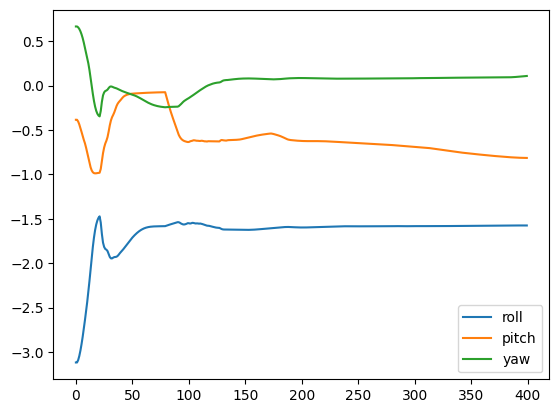

numActiveThreads = 0


frame= 2165 fps= 77 q=-1.0 Lsize=    1411kB time=00:00:36.03 bitrate= 320.8kbits/s speed=1.28x    
video:1385kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.891344%
[libx264 @ 0x55b4993c8ec0] frame I:9     Avg QP:16.99  size: 47400
[libx264 @ 0x55b4993c8ec0] frame P:545   Avg QP:24.37  size:  1515
[libx264 @ 0x55b4993c8ec0] frame B:1611  Avg QP:32.22  size:   103
[libx264 @ 0x55b4993c8ec0] consecutive B-frames:  0.7%  0.1%  0.1% 99.0%
[libx264 @ 0x55b4993c8ec0] mb I  I16..4: 33.0% 38.1% 28.9%
[libx264 @ 0x55b4993c8ec0] mb P  I16..4:  0.2%  0.2%  0.1%  P16..4:  2.9%  1.3%  1.0%  0.0%  0.0%    skip:94.3%
[libx264 @ 0x55b4993c8ec0] mb B  I16..4:  0.1%  0.1%  0.0%  B16..8:  2.4%  0.0%  0.0%  direct: 0.0%  skip:97.4%  L0:49.6% L1:50.3% BI: 0.2%
[libx264 @ 0x55b4993c8ec0] 8x8 transform intra:41.2% inter:9.7%
[libx264 @ 0x55b4993c8ec0] direct mvs  spatial:99.3% temporal:0.7%
[libx264 @ 0x55b4993c8ec0] coded y,uvDC,uvAC intra: 15.0% 21.6% 17.5% inter: 0.3% 0.2

stopping threads
destroy semaphore
Thread with taskId 0 exiting
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


c,ddl,ddr,vr,hd,vl,hu: 38%  7% 48%  1%  1%  1%  1%  1%  1%
[libx264 @ 0x55b4993c8ec0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 23% 28% 20%  4%  6%  3%  7%  3%  7%
[libx264 @ 0x55b4993c8ec0] i8c dc,h,v,p: 55% 29% 14%  2%
[libx264 @ 0x55b4993c8ec0] Weighted P-Frames: Y:0.0% UV:0.0%
[libx264 @ 0x55b4993c8ec0] ref P L0: 70.0%  5.9% 12.5%  5.3%  6.3%
[libx264 @ 0x55b4993c8ec0] ref B L0: 78.7% 17.3%  2.9%  1.1%
[libx264 @ 0x55b4993c8ec0] ref B L1: 92.3%  7.7%
[libx264 @ 0x55b4993c8ec0] kb/s:314.27


In [ ]:
''' Create Robot Instance'''
import pybullet as p
import os
import pybullet_data  # make sure this is installed in your venv
import numpy as np


null_space_enabled = True


data_path = pybullet_data.getDataPath()
urdf_path = os.path.join(data_path, "franka_panda", "panda.urdf")

logId = p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4, "robot_animation.mp4")   
pandaUid = p.loadURDF(urdf_path, useFixedBase=True)
# pandaUid = p.loadURDF(os.path.join(pybullet_data.getDataPath(), "franka_panda\\panda.urdf"),useFixedBase=True)
p.resetBasePositionAndOrientation(pandaUid, [0, 0, 0], [0, 0, 0, 1])
initialJointPosition = [0,-np.pi/4,np.pi/4,-np.pi/4,np.pi/4,np.pi/4,np.pi/4,0,0,0,0,0]
# initialJointPosition = [0,0,0,0,0,0,0,0,0,0,0,-np.pi/2]
robot = eye_in_hand_robot(pandaUid,initialJointPosition)
p.stepSimulation() # need to do this to initialize robot
eRc = np.array([[1,0,0],[0,-1,0],[0,0,-1]])
cRe = eRc.T
angles = []
frames = []
for ITER in range(400):
    p.stepSimulation()
    '''Q3b'''
    # object_center=[0.5+0.2*np.sin(np.pi/2+ITER/10), 0.5+0.2*np.sin(ITER/20), 0.01]
    # p.resetBasePositionAndOrientation(boxId,object_center,p.getQuaternionFromEuler(object_orientation))
 
    ''' Match Camera Pose to Robot End-Effector and Get Image'''
    cameraPosition, cameraOrientation = robot.get_ee_position()
    rgb, depth = get_camera_img_float(cameraPosition, cameraOrientation)
    joint_positions = robot.get_current_joint_angles()
    roll,pitch,yaw = Rot.from_matrix(cameraOrientation).as_euler('xyz', degrees=False)
    angles.append([roll,pitch,yaw])


    print("roll angle is",roll,pitch,yaw)
    
    ''' Magical Computer Vision Algorithm that gets locations of objects in the image, as object_loc (Do Not Remove)'''
    viewMat, projMat = get_camera_view_and_projection_opencv(cameraPosition, cameraOrientation)
    object_loc = opengl_plot_world_to_pixelspace(object_center, viewMat, projMat,camera_width, camera_height)

    ''' Do some things here to get robot control'''
    imageJacobian = getImageJacobian(object_loc[0], object_loc[1], depth, camera_focal_depth, camera_width, camera_height)
    delta_X, delta_Omega = findCameraControl(object_location_desired, object_loc, imageJacobian)
    dtheta_cartesian = convert_delta_omega_to_cartesian(cameraOrientation,0.1*K_p_Omega*(delta_Omega))
    dtheta_cartesian = dtheta_cartesian.reshape(-1,1)
    dX_cartesian =  0.4*K_p_x*(cameraOrientation@delta_X.reshape(-1,1))
    new_jointPositions = findJointControl(robot, dX_cartesian, dtheta_cartesian,null_space_enabled,roll,-np.pi/2,alpha= 0.9)
    print("new_jointPositions is",new_jointPositions) 
    #set Next Joint Targets
    # new_jointPositions = []
    robot.set_joint_position(new_jointPositions)
    
    # show image
    cv2.circle(rgb, (int(camera_width/2), int(camera_height/2)), 5, (0, 255, 0), -1)
    cv2.circle(rgb, (object_loc[0],object_loc[1]), 5, (255, 0, 255), -1)
    cv2.imshow("depth", depth)
    cv2.imshow("rgb", rgb)
    frames.append(Image.fromarray(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)))  # cv2 uses BGR, PIL uses RGB
    cv2.waitKey(1)
frames[0].save(
    'simulation.gif',
    save_all=True,
    append_images=frames[1:],
    duration=50,  # milliseconds per frame (adjust for speed)
    loop=0  # 0 = infinite loop
)
#close the physics server
cv2.destroyAllWindows()    
from matplotlib import pyplot as plt
angles = np.array(angles)
plt.plot(angles[:,0],label='roll')
plt.plot(angles[:,1],label='pitch')
plt.plot(angles[:,2],label='yaw')
plt.legend()
plt.show()
p.stopStateLogging(logId)
p.disconnect() 

In [ ]:
p.get_jacobian_at_current_position()

AttributeError: module 'pybullet' has no attribute 'get_jacobian_at_current_position'